This week I'll be adding the ability to control energy loss from various parameters. What I've got working so far:

* Electromagnetic radiation
* Gravitational radiation
* Field Decay
    
All of these effects can be toggled on and off so as to examine any one effect in particular. By default the EM losses are turned on, as that produces the simplest model. The code as set up will generate three sets of plots, which I'll describe in detail below the code.

Integrating..........


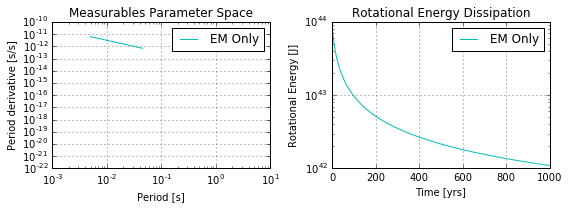

Integrating..........


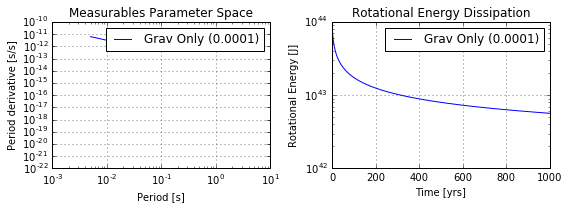

Integrating..........


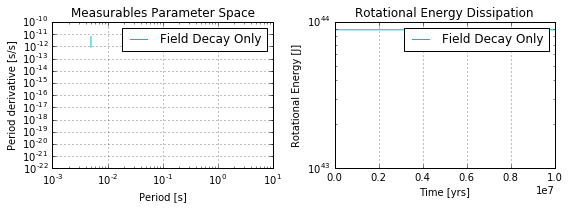

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evolve( mass, period, period_dot, bumpyness = 0, loss_grav = False, 
           loss_em = True, field_decay = False, accrete_function = None, 
           max_time = 1e3, step=1):
    '''
    Function that will evolve a neutron star with given initial parameters 
    forward in time using most likely a simple Eulerian integration. Energy 
    flow via different means will be togglable such that we can examine the 
    effect of different processes
    
    Input:
    ======
    mass (float) : mass in solar units. Required.
    
    period (float) : period in seconds. Required.
    
    period_dot (float) : period derivative, which is unitless. Required.
    
    bumpyness (float) : 0-1 value of the structure irregularity. Important for 
        gravitational energy loss. Defaults to 0 (symmetric neutron star)
    
    loss_grav (bool) : Control for loss due to gravitational modes. Defaults 
        to False.
    
    loss_em (bool) : Control for loss due to electromagnetic processes. 
        Defaults to True.
    
    field_decay (bool) : Control for decay of magnetic field via various 
        processes. Defaults to False.
    
    accrete_function (function) : A function of time which will return an 
        accretion rate. Used to turn on or off accretion for the star.
    
    max_time (float) : Time in years when simulation will cut off. Defaults to 
        1e3 years
        
    step (float) : Size of integration step in years. Defaults to 1
        
    Output:
    ======
    data (DataFrame) : A dateframe object containing the various energy values 
        over time.
    '''
    
    # Constant Stuff
    mass *= 2e30 # convert from solar to kg
    radius = 1e4 # meters, might be function of mass later
    MoI = (2/5) * mass * radius**2 # moment of interia
    grav_constants = 4*(2*np.pi)**6 * (6.67e-11)/(3e8)**5 * mass**2 * radius**4
    dt = step*3.15e7 # timestep in seconds
    
    # Some initial values
    mag_field_initial = 3.2e19 * np.sqrt(period*period_dot) # G
    energy_rot_initial = 2 * np.pi**2 * MoI / period**2
    em_lum_initial = 4 * np.pi**2 * MoI * period_dot / period**3
    grav_lum_initial = grav_constants * bumpyness**2 / period**6
    
    # Start some lists
    time_data = [0]
    period_data = [period]
    period_dot_data = [period_dot]
    energy_rot_data = [energy_rot_initial]
    em_lum_data = [em_lum_initial]
    grav_lum_data = [grav_lum_initial]
    mag_field_data = [mag_field_initial]
    
    # Integrator
    total_steps = int(max_time/step)
    print("Integrating", end='')
    for i in range(total_steps):
        
        # Denote new time instance
        new_time = time_data[-1] + dt/3.15e7
        if (100*i/total_steps)%10==0:
            print('.', end='')
        
        # Electromagnetic Losses
        if loss_em == True:
            em_lum_new = 4 * np.pi**2 * MoI * period_dot_data[-1] / period_data[-1]**3
        else:
            em_lum_new = 0
        
        # Gravitational Losses
        if loss_grav == True:
            grav_lum_new = grav_constants * bumpyness**2 / period_data[-1]**6
        else:
            grav_lum_new = 0
            
        # Accretion Gains or Losses
        pass # change me
    
        # Account for magnetic field decay
        if field_decay == True:
            new_mag_field = mag_field_initial * np.exp(-new_time/(1e7))
        else:
            new_mag_field = mag_field_data[-1]
            
        
            
        # Change energy
        total_lum = em_lum_new + grav_lum_new
        energy_new = energy_rot_data[-1] - total_lum * dt
        if energy_new<0:
            break
        period_new = np.sqrt(2 * np.pi**2 * MoI / energy_new )
        period_dot_new = (new_mag_field/3.2e19)**2 / period_new
        
        
        
        time_data.append(new_time)
        period_data.append(period_new)
        period_dot_data.append(period_dot_new)
        energy_rot_data.append(energy_new)
        em_lum_data.append(em_lum_new)
        grav_lum_data.append(grav_lum_new)
        mag_field_data.append(new_mag_field)
        
    
    data = pd.DataFrame({
        'time': time_data,
        'period': period_data,
        'period_dot': period_dot_data,
        'energy': energy_rot_data,
        'em_lum': em_lum_data,
        'grav_lum': grav_lum_data,
        'mag_data': mag_field_data
    })
    
    print()
    return data

def displays( df_star, mylabel):
    '''
    Input dataframe output plots
    '''
    rc=np.random.choice(['r','g','b','c','m','y'])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
    ax1.loglog(df_star['period'], df_star['period_dot'], label=mylabel, c=rc)
    ax1.set_xlim(1e-3,1e1)
    ax1.set_ylim(1e-22, 1e-10)
    ax1.set_xlabel("Period [s]")
    ax1.set_ylabel("Period derivative [s/s]")
    ax1.set_title('Measurables Parameter Space')
    ax1.legend()
    ax1.grid()
    
    ax2.semilogy(df_star['time'], df_star['energy'], label=mylabel, c=rc)
    ax2.set_xlabel('Time [yrs]')
    ax2.set_ylabel('Rotational Energy [J]')
    ax2.set_title('Rotational Energy Dissipation')
    ax2.legend()
    ax2.grid()
    plt.tight_layout()
    plt.show()
    
    return None

# EM Only
a = evolve(1.4, 0.005, 6.3e-12)
displays(a, 'EM Only')

# Grav Only
b = evolve(1.4, 0.005, 6.3e-12, bumpyness=0.0001, loss_grav=True, loss_em=False)
displays(b, 'Grav Only (0.0001)')

# Field Decay Only
c = evolve(1.4, 0.005, 6.3e-12, loss_em=False, field_decay=True, max_time=1e7, step=10)
displays(c, 'Field Decay Only')


The above code should (hopefully) produce three sets of plots. Each one consists of a pair of plots, plot of the motion through the P-dPdt parameter space (which is generally considered to be the HR-diagram equivalent for neutron stars, as they're two of the fundemental properties we can observe), as well as a plot which shows the rotational energy as a function of time; more rotational energy gives a faster neutron star.

For the first set, we have a neutron star which is just radiating electromagnetically through the standard known process over 1000 years. The energy available for rotation dropped by a factor of almost 100, and we had motion toward the bottom right (which is typical for a star which is slowing down).

The second set shows a star in which I've induced a bit of bumpyness. Basically even the smallest bumps on a neutron star will be whipping around very quickly, which will produce gravitational waves. The equation I have to model this is a function of $s^2$ where s is some generic measurement of how lumpy it is. I'm investigating better approaches, but it's neat that by introducing even a fairly small anisotropy we can make the star loss energy at a similar rate over that 1000 year time scale.

The third set is less simple. [This paper by Goldreich](https://ui.adsabs.harvard.edu/?#abs/1992ApJ...395..250G) notes that neutron star magnetic fields should decay via various (complicated) processes over the course of 1e7 years. In the third set I've turned on field decay, but turned off all other effects, just to see what a neutron star would do if the only thing that happened was field decay. I've used this equation to model the effect in my code:

$$
    B = B_0 \exp{\left( \frac{-t}{1 \times 10^7\ \textrm{yrs}} \right)}
$$

As it turns out, it moves straight down on the Ppdot diagram, because the period won't change (the magnetic field doesn't effect the period, but it can effect how quickly the period changes, if that makes sense). To get this to show though I've had to look at much longer timescales than in the previous two sets, but the effect when combined is very cool. I'll save that as a teaser for next week's.

What I need to work on for next assignment is building up an accretion modifier. I know how I'd like to tackle that problem, and the results could be really neat, like being able to "spin up" nearly dead stars, or maybe procude magnetars (accretion early in life could produce spins strong enough. If I can add that and perhaps find better ways to model the gravitational radiation and the field decay, I'd be golden! 